In [183]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 

from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import torch
# Folium setup.
import folium

In [184]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0113/npy/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples,)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

4it [00:00, 44.91it/s]


Now all merge samples are saved!


In [185]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)

(4468, 1, 2)
(1118, 1, 2)


In [186]:
kernel=9
bands=40
number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  kernel,kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)



In [187]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]
X_val= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)

In [188]:
number_samples = X_train.shape[0]
X_train_rf = np.reshape(X_train, (number_samples,  kernel*kernel*bands))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)

Post-processed S2_train data shape:  (4468, 3240)


In [189]:
number_samples_v = X_val.shape[0]
X_val_rf = np.reshape(X_val, (number_samples_v, kernel*kernel*bands))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (1118, 3240)


In [190]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [191]:
y_pred_rf = rf_classifier.predict(X_val_rf)

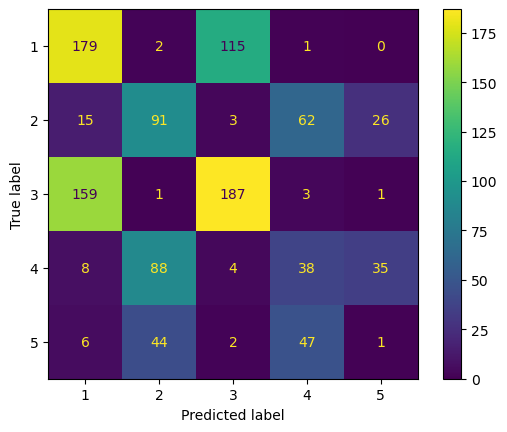

Accuracy Random Forest Classifier:  0.44364937388193204


In [192]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

In [193]:
number_samples = X_train.shape[0]
X_train_nn= np.zeros((number_samples,  kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn[i,:] = np.reshape(X_train[i,:], (  kernel*kernel,bands))
    X_train_nn[i,:]= np.array(pd.DataFrame(X_train_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn.shape)

Post-processed S2_train data shape:  (4468, 81, 40)


In [194]:
number_samples = X_val.shape[0]
X_val_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn[i,:] = np.reshape(X_val[i,:], (  kernel*kernel,bands))
    X_val_nn[i,:]= np.array(pd.DataFrame(X_val_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_val_nn.shape)

Post-processed S2_train data shape:  (1118, 81, 40)


In [195]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(kernel*kernel,bands)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(16, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [196]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [197]:
history = simple_model.fit(X_train_nn, Y_train, epochs=200,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=50)],  verbose=0,validation_data=(X_val_nn, Y_val))

Epoch 1/200


2023-01-13 07:57:31.466230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-13 07:57:32.594264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 2s 11ms/sample - loss: 1.3367 - accuracy: 0.4009 - val_loss: 1.0881 - val_accuracy: 0.4848
Epoch 51/200
140/140 [==============================] - 1s 6ms/sample - loss: 0.9053 - accuracy: 0.5461 - val_loss: 0.9301 - val_accuracy: 0.5358
Epoch 101/200
140/140 [==============================] - 1s 6ms/sample - loss: 0.8428 - accuracy: 0.5819 - val_loss: 0.9148 - val_accuracy: 0.5483
Epoch 151/200
140/140 [==============================] - 1s 6ms/sample - loss: 0.8257 - accuracy: 0.5893 - val_loss: 0.9236 - val_accuracy: 0.5233


In [198]:
y_pred_dl_p = simple_model.predict(X_val_nn)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

35/35 [==============================] - 0s 3ms/step
Prediction example:  [8.6162292e-18 1.1515547e-06 3.8717955e-01 4.0047789e-06 4.2239150e-01
 1.9042383e-01 8.7557746e-18 7.8186112e-18 5.9199898e-18 4.2147532e-18
 7.3212912e-18 8.2080404e-18 1.0796304e-17 6.7613615e-18 4.0045216e-18
 4.5874060e-18]  Class:  4


2023-01-13 08:00:27.165018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


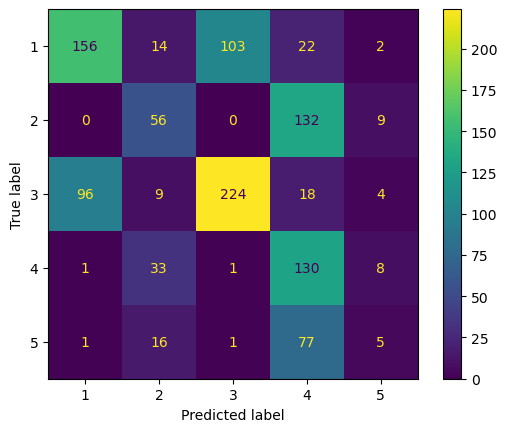

Accuracy Simple Deep Learning model:  0.5107334525939177


In [199]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

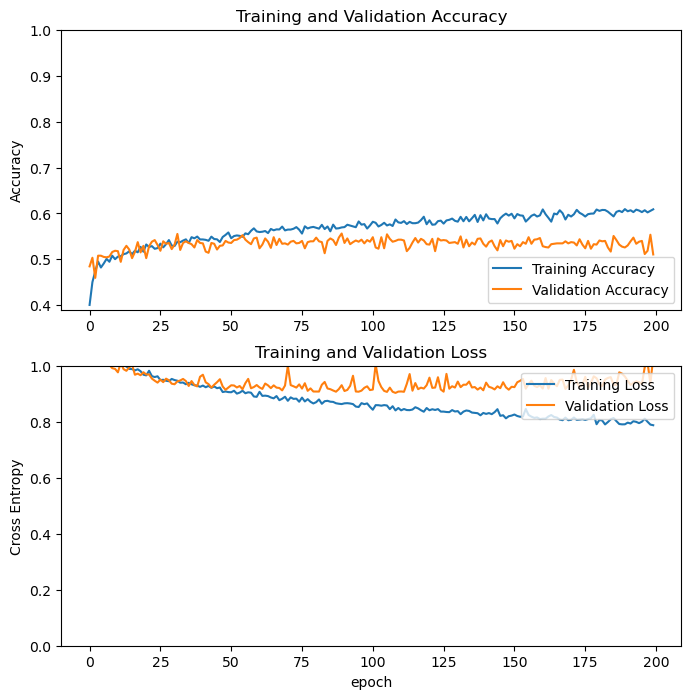

In [200]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [201]:
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu",input_shape=(kernel*kernel,bands,1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
]
)

In [202]:

model.summary() 

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 81, 40, 64)        640       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 40, 20, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 40, 20, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 20, 10, 64)       0         
 g2D)                                                            
                                                                 
 flatten_29 (Flatten)        (None, 12800)             0         
                                                                 
 dense_56 (Dense)            (None, 64)              

In [203]:

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(16))

In [204]:

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 81, 40, 64)        640       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 40, 20, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 40, 20, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 20, 10, 64)       0         
 g2D)                                                            
                                                                 
 flatten_29 (Flatten)        (None, 12800)             0         
                                                                 
 dense_56 (Dense)            (None, 64)              

In [205]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train_nn, Y_train, epochs=10, 
                    validation_data=(X_val_nn, Y_val))
     

Epoch 1/10


2023-01-13 08:00:54.480262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - ETA: 0s - loss: 1.4633 - accuracy: 0.3534

2023-01-13 08:00:57.899596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 4s 25ms/step - loss: 1.4633 - accuracy: 0.3534 - val_loss: 1.1025 - val_accuracy: 0.4741
Epoch 2/10
140/140 [==============================] - 3s 21ms/step - loss: 1.0679 - accuracy: 0.4519 - val_loss: 1.0063 - val_accuracy: 0.4830
Epoch 3/10
140/140 [==============================] - 3s 20ms/step - loss: 1.0254 - accuracy: 0.4790 - val_loss: 0.9844 - val_accuracy: 0.4964
Epoch 4/10
140/140 [==============================] - 3s 20ms/step - loss: 1.0249 - accuracy: 0.4870 - val_loss: 0.9927 - val_accuracy: 0.5045
Epoch 5/10
140/140 [==============================] - 3s 20ms/step - loss: 0.9966 - accuracy: 0.4931 - val_loss: 0.9534 - val_accuracy: 0.5242
Epoch 6/10
140/140 [==============================] - 3s 20ms/step - loss: 0.9718 - accuracy: 0.5188 - val_loss: 0.9363 - val_accuracy: 0.5125
Epoch 7/10
140/140 [==============================] - 3s 20ms/step - loss: 0.9674 - accuracy: 0.5081 - val_loss: 0.9492 - val_accuracy: 0.5277
Epoch 8/10

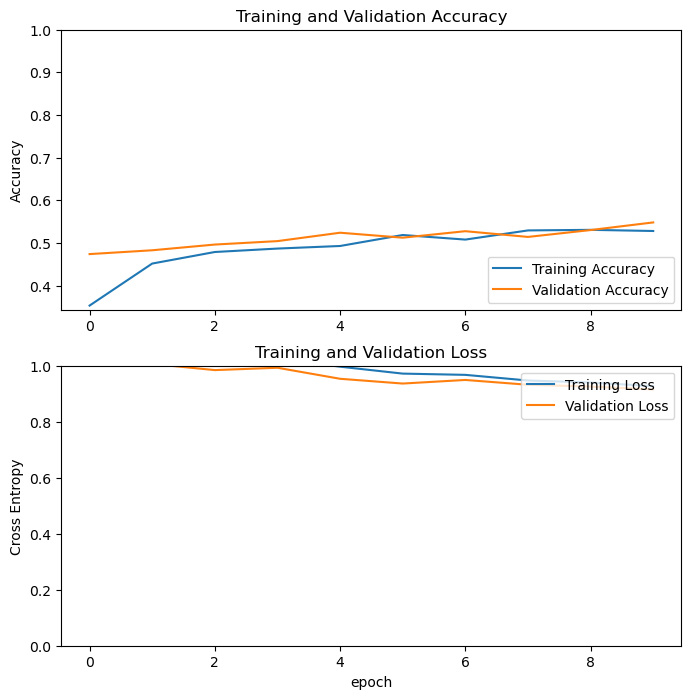

In [206]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [207]:
y_pred_cnn_p = model.predict(X_val_nn)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

17/35 [=============>................] - ETA: 0s

2023-01-13 08:01:50.810944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 0s 7ms/step
Prediction example:  [-8.669854   -0.99940825  3.8881056  -0.42709956  3.8195517   3.4804246
 -6.691006   -8.583006   -8.686239   -8.613282   -6.8200407  -6.873555
 -9.463559   -6.7213235  -6.763398   -7.3658724 ]  Class:  2


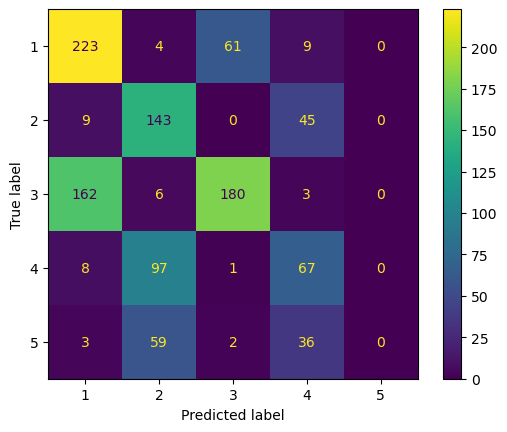

Accuracy Simple Deep Learning model:  0.5483005366726297


In [208]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)